In [91]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tt
from torchvision.transforms import Compose
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

%matplotlib inline

In [ ]:
!pip install -U pandas-profiling

In [ ]:
!pip install -U featuretools

In [ ]:
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [2]:
# Make copy of dataset to colab storage
!cp /content/drive/MyDrive/Category\ and\ Attribute\ Prediction\ Benchmark/Img/img.zip ./

In [ ]:
!unzip ./img.zip

In [ ]:
"""
- Fashion Landmark Annotations (Anno/list_landmarks.txt)
	fashion landmark labels. See LANDMARK LABELS section below for more info.

- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt)
	clothing category labels. See CATEGORY LABELS section below for more info.

- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt)
	clothing attribute labels. See ATTRIBUTE LABELS section below for more info.
"""

In [20]:
# f = open("./list_category_img.txt", "r")
# print(f.readlines())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
!cp /content/drive/MyDrive/Category\ and\ Attribute\ Prediction\ Benchmark/Anno_coarse/list_category_img.txt ./
!cp /content/drive/MyDrive/Category\ and\ Attribute\ Prediction\ Benchmark/Anno_coarse/list_attr_img.txt ./

In [63]:
import pandas as pd
df_attr = pd.read_csv("./list_category_img.txt", 
                       chunksize=10, 
                       sep = '\s+',
                       skiprows=[0,1],
                       names = ['Image','Category'])

result = df_attr.get_chunk(1000000)
print(result)

np_att = np.array(result)

                                                    Image  Category
0         img/Sheer_Pleated-Front_Blouse/img_00000001.jpg         3
1         img/Sheer_Pleated-Front_Blouse/img_00000002.jpg         3
2         img/Sheer_Pleated-Front_Blouse/img_00000003.jpg         3
3         img/Sheer_Pleated-Front_Blouse/img_00000004.jpg         3
4         img/Sheer_Pleated-Front_Blouse/img_00000005.jpg         3
...                                                   ...       ...
289217  img/Paisley_Print_Babydoll_Dress/img_00000050.jpg        41
289218  img/Paisley_Print_Babydoll_Dress/img_00000051.jpg        41
289219  img/Paisley_Print_Babydoll_Dress/img_00000052.jpg        41
289220  img/Paisley_Print_Babydoll_Dress/img_00000053.jpg        41
289221  img/Paisley_Print_Babydoll_Dress/img_00000054.jpg        41

[289222 rows x 2 columns]


In [66]:
np_att[0][0]

'img/Sheer_Pleated-Front_Blouse/img_00000001.jpg'

In [79]:
import PIL
from PIL import Image

for i in range(np_att.shape[0]):
    img_path = os.path.join('./', np_att[i+2][0])
    png = Image.open(img_path)
    category = np_att[i+2][1]
    # print(png.load()) 
    break

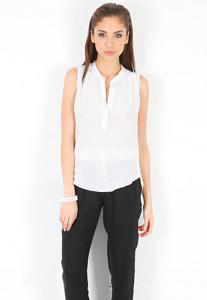

In [81]:
png

In [83]:
category

3

In [101]:
# Custom dataset for zipping input and output images
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, combine_dir, transform, transform_size=32):
        # One Folder with training inputs and outputs 
        self.combine_dir = combine_dir
        self.both_dir = os.listdir(combine_dir)
        self.transform = transform
        self.input_dir = './'
        all_imgs = []
        category = []

        df_attr = pd.read_csv("./list_category_img.txt", 
                       chunksize=10, 
                       sep = '\s+',
                       skiprows=[0,1],
                       names = ['Image','Category'])
        result = df_attr.get_chunk(1000000)
        np_att = np.array(result)

        for i in range(np_att.shape[0]):
            all_imgs.append(os.path.join('./', np_att[i][0]))
            # png = Image.open(img_path)
            category.append(np_att[i][1])

        
        # # Input - Output dir
        # # self.input_dir = os.path.join(combine_dir, self.both_dir[0])
        # # self.outut_dir = os.path.join(combine_dir, self.both_dir[1])
        # self.input_dir =  in_path
        # self.outut_dir =  out_path

        # all_imgs = os.listdir(self.input_dir)
        # all_imgs_2 = os.listdir(self.outut_dir)
        # count=0
        # for dir in all_imgs:
        #     if not dir in all_imgs_2:
        #         count+=1
        #         all_imgs.remove(dir)

        #     # if dir in ["/svg841.png", "/svg786.jpg", "/svg4034.jpg", "/svg947.jpg", "/svg4023.jpg"] or dir[-3] == "s" or dir[-4] == "s" or dir == "/svg987.jpg" or dir == "/svg971.jpg" or dir == "/svg903.jpg" or dir == "/svg921.jpg" or dir == "svg712.jpg" or dir == "/svg886.jpg" or dir == "/svg750.png" or dir == "/svg4015.png":
        #     if dir[-3] == "s" or dir[-4] == "s" or dir in remove_from:
        #         if dir in all_imgs:
        #             count+=1
        #             all_imgs.remove(dir)

        # print(count)

        self.total_imgs = all_imgs #natsort.natsorted(all_imgs)
        self.totla_cate  = category

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        # Load input images
        in_img_loc = os.path.join(self.input_dir, self.total_imgs[idx])
        input_image = Image.open(in_img_loc).convert("RGB")
        input_tensor = self.transform(input_image)

        # Load output images
        catogery_label = self.totla_cate[idx] 

        return input_tensor, catogery_label

In [116]:
size = 256
dataset = CustomDataSet("./", 
                        transform=Compose([ 
                        tt.Resize((size,size),interpolation=Image.ANTIALIAS),
                        tt.ToTensor()]),
                        transform_size=size)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [117]:
# Dowloading dataset and defining dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True)

In [118]:
# Define function to display dataset
def denorm(img_tensor):
    return img_tensor

def show_images(images):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([]);
    print(images.shape)
    ax.imshow( make_grid( denorm(images.detach()[:64]), nrow=8).permute((1,2,0)))
    

def show_batch(data_loader):
    for images, _ in data_loader:
        show_images(images)
        return _

def show_output(data_loader):
    for _, images in data_loader:
        show_images(images)
        break;

torch.Size([64, 3, 256, 256])


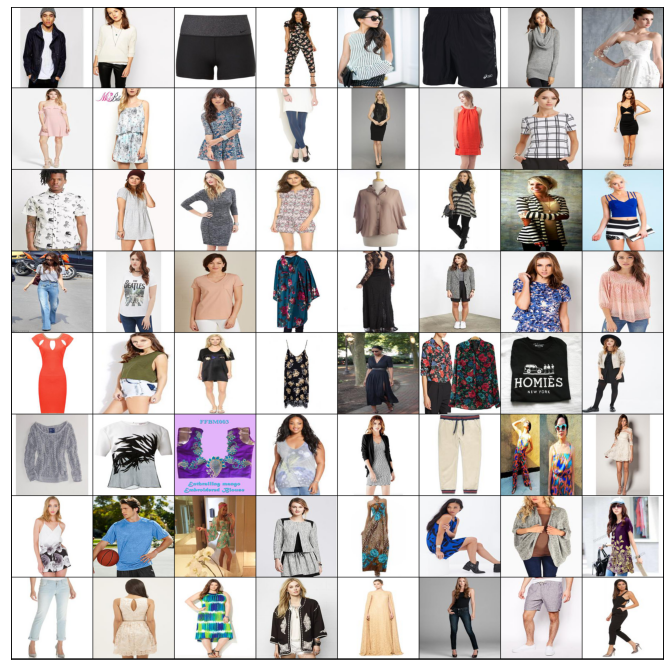

In [119]:
# Display training samples
category = show_batch(train_loader)

In [120]:
category

tensor([ 1, 16, 32,  6,  3, 32,  6, 41, 41, 48, 41, 30, 41, 41, 19, 41, 18, 41,
        16, 48,  3,  6,  3, 19, 26, 18,  6, 41, 41, 11,  3,  3, 41, 17, 41, 41,
        33,  3, 17, 41, 16,  3,  3, 18,  2, 34, 42, 41, 48, 18, 44,  2, 41, 41,
         6,  3, 26, 41, 41, 44, 41, 30, 29, 42])

In [121]:
# Setup GPU configuration and DeviceDataLoader for efficient GPU memory usage
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
    ''' Loading data to device '''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in  data]
    else:
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
!pip install vit-pytorch

In [111]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)


In [112]:
v

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=1024, out_features=2048, bias=True)
              (1): GELU()
        

In [114]:
v.mlp_head = nn.LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

In [115]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViT( image_size = 256,
                        patch_size = 32,
                        num_classes = 1000,
                        dim = 1024,
                        depth = 6,
                        heads = 16,
                        mlp_dim = 2048,
                        dropout = 0.1,
                        emb_dropout = 0.1  )
        
        self.vit.mlp_head = nn.LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

        self.category_head = nn.Sequential( nn.Linear(1024, 50))
        self.attribute_head = nn.Sequential( nn.Linear(1024, 1000))

    def forward(self, images):
        out = self.vit(images)
        pred_category = self.category_head(out)
        pred_attribute = self.attribute_head(out)

        return pred_category, pred_attribute



In [122]:
import pandas as pd
df_attr = pd.read_csv("./list_attr_img.txt", 
                       chunksize=10, 
                       sep = '\s+',
                       skiprows=[0,1],
                       names = ['Image','Category'])

result = df_attr.get_chunk(10)
print(result)

np_att = np.array(result)